In [1]:
"""
Train the seq2seq network on 5 PCA features of each frame on the input data.
"""
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import pickle
import random
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from transformer import buildTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = "cpu"

cuda


In [2]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
#     loc = ticker.MultipleLocator(base=0.2)
#     ax.yaxis.set_major_locator(loc)
    %matplotlib inline
    plt.plot(points)

In [3]:
"""
Randomly drop 5, 10, 15, 20% frames from each sentence, to perfrorm augmentation.
"""
def augment_all(temp):
    r_5 = remove_5(temp)
    r_10 = remove_10(temp)
    r_15 = remove_15(temp)
    r_20 = remove_20(temp)
    
    temp = np.vstack((temp, r_5))
    temp = np.vstack((temp, r_10))
    temp = np.vstack((temp, r_15))
    temp = np.vstack((temp, r_20))
    
    return temp

In [4]:
# randomly drop 15% of frames
def remove_15(temp):
    for i in range(temp.shape[0]):
        x = temp[i][0]
#         print("before : ",temp[i][0].shape)
        removed_indexes = np.random.randint(0, x.shape[0],np.int(np.floor(x.shape[0]*0.15)))
        selected_indexes = np.setdiff1d(np.arange(x.shape[0]),removed_indexes)
        temp[i][0] = x[selected_indexes]
#         print('After: ', temp[i][0].shape)
        
    return temp

# randomly drop 5% of frames
def remove_5(temp):
    for i in range(temp.shape[0]):
        x = temp[i][0]
#         print("before : ",temp[i][0].shape)
        removed_indexes = np.random.randint(0, x.shape[0],np.int(np.floor(x.shape[0]*0.05)))
        selected_indexes = np.setdiff1d(np.arange(x.shape[0]),removed_indexes)
        temp[i][0] = x[selected_indexes]
#         print('After: ', temp[i][0].shape)
        
    return temp

# randomly drop 20% of frames
def remove_20(temp):
    for i in range(temp.shape[0]):
        x = temp[i][0]
#         print("before : ",temp[i][0].shape)
        removed_indexes = np.random.randint(0, x.shape[0],np.int(np.floor(x.shape[0]*0.20)))
        selected_indexes = np.setdiff1d(np.arange(x.shape[0]),removed_indexes)
        temp[i][0] = x[selected_indexes]
#         print('After: ', temp[i][0].shape)
        
    return temp


# randomly drop 10% of frames
def remove_10(temp):
    for i in range(temp.shape[0]):
        x = temp[i][0]
#         print("before : ",temp[i][0].shape)
        removed_indexes = np.random.randint(0, x.shape[0],np.int(np.floor(x.shape[0]*0.10)))
        selected_indexes = np.setdiff1d(np.arange(x.shape[0]),removed_indexes)
        temp[i][0] = x[selected_indexes]
#         print('After: ', temp[i][0].shape)
        
    return temp

In [5]:
sentence_data = np.load('PCA_5feat_sentence_frame_mapped_l10.npy')
# sentence_data_w1 = np.load('sentence_frame_mapped_w1_42.npy')
# sentence_data_w3 = np.load('sentence_frame_mapped_w3_42.npy')

# sentence_data = np.vstack((sentence_data,sentence_data_w1))
# sentence_data = np.vstack((sentence_data,sentence_data_w3))
# print("Before Augmentation: ",sentence_data.shape)
# sentence_data = augment_all(sentence_data)
print("After Augmentation: ", sentence_data.shape)

After Augmentation:  (570, 2)


In [6]:
# Normalize the features between 0 and 10
temp = []
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

for i in range(sentence_data.shape[0]):
    if sentence_data[i][0].shape[0]!=0:
        sentence_data[i][0] = scale(sentence_data[i][0],0,10)
        temp.append(sentence_data[i])
temp = np.array(temp)
sentence_data = temp
DATA_SHAPE = sentence_data.shape[0]
print(DATA_SHAPE)

568


In [7]:
print(sentence_data.shape)
print(sentence_data[0,0].shape)

(568, 2)
(127, 5)


In [8]:
print(sentence_data.shape)

def get_sentence_data(num,n_data_pts):
    num = num%n_data_pts
#     num = num%sentence_data.shape[0]
    return [torch.FloatTensor(sentence_data[num][0]).to(device), sentence_data[num][1]]
#     return [torch.FloatTensor(sentence_data[1][0]).to(device), sentence_data[1][1]]
# print(get_sentence_data(0))

(568, 2)


In [9]:
# We’ll need a unique index per word to use as the inputs and targets of the networks later. 
# To keep track of all this we will use a helper class called Lang which has word → index (word2index) and 
# index → word (index2word) dictionaries, as well as a count of each word word2count to use to later replace rare words.

SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [10]:
# The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, 
# and trim most punctuation.

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
#     s = re.sub(r"([.!?])", r" \1", s)
#     s = re.sub(r"[^a-zA-Z]+", r" ", s)
    return s

In [11]:
# To read the data file we will split the file into lines, and then split lines into pairs. 
# The files are all English → Other Language, so if we want to translate from Other Language → English 
# I added the reverse flag to reverse the pairs.

def readLangs():
    pairs = [get_sentence_data(i,DATA_SHAPE) for i in range(DATA_SHAPE)]
    for i in range(len(pairs)):
        pairs[i][1] = normalizeString(pairs[i][1])
    

    output_lang = Lang('english')

    return output_lang, pairs

In [2]:
help(random.choice)

Help on method choice in module random:

choice(self, seq) method of random.Random instance
    Choose a random element from a non-empty sequence.



In [12]:
def prepareData():
    output_lang, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(output_lang.name, output_lang.n_words)
    return output_lang, pairs

output_lang, pairs = prepareData()
print(output_lang)
choice = random.choice(pairs)
print(choice[0].size(), choice[1])


Read 568 sentence pairs
Counting words...
Counted words:
english 1905
<__main__.Lang instance at 0x7fd843fb1200>
torch.Size([193, 5]) than fs-rit gallaudet have great tradition strange tradition fs-rit none


In [16]:
print(len(choice[0]))

104


In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = pair[0]
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return [input_tensor, target_tensor]

training_pairs = [tensorsFromPair(pairs[i]) for i in range(DATA_SHAPE)]
#print(training_pairs[0])

In [14]:
MAX = max(np.array(pairs)[:,1], key=len)
print(MAX)
print(len(MAX), "characters")

then cl"leave" to/until machine cl"skin through machine and needles" fs-holes cl"holes" (s)elasti+ cl"stretchy graft put on arm" cl"invisible"
142 characters


In [15]:
MAX_LENGTH_FRAMES = int(max(np.array(pairs)[:,0], key=len).shape[0]/10)
print(MAX_LENGTH_FRAMES)


37


In [45]:
def trainIters(model, n_iters,n_data_pts, criterion, print_every=10, plot_every=10, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)    
    
    training_pairs = np.array([tensorsFromPair(pairs[i]) for i in range(n_data_pts)])
#     randomselect = random.sample(range(training_pairs.shape[0]),training_pairs.shape[0])
#     training_pairs = training_pairs[randomselect]
    
    #criterion = nn.NLLLoss()
    
    iter_loss = []

    for i in range(1,n_iters+1):
        for iter in range(1, n_data_pts + 1):
            training_pair = training_pairs[iter-1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]
#             print(target_tensor)
            if input_tensor.size(0) < 21:
                pass
            else:
                
            print_loss_total += loss
            plot_loss_total += loss
        
        print_loss_total = print_loss_total / n_data_pts
        plot_loss_total = plot_loss_total / n_data_pts
        
        
        if i % print_every == 0:
            print_loss_avg = print_loss_total #/ print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, i / (n_iters)),
                                         i, i / (n_iters) * 100, print_loss_avg))
        
        if i % plot_every == 0:
            plot_loss_avg = plot_loss_total #/ plot_every
            iter_loss.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(iter_loss)
    
    return iter_loss

In [16]:
pair = tensorsFromPair(pairs[1])
print(pair[0].size(), pair[1].size())

torch.Size([160, 5]) torch.Size([11, 1])


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0m 2s (- 4m 19s) (1 1%) 7.5312
0m 5s (- 4m 20s) (2 2%) 7.3447
0m 8s (- 4m 20s) (3 3%) 6.8624
0m 10s (- 4m 18s) (4 4%) 5.4218
0m 13s (- 4m 14s) (5 5%) 3.4488
0m 15s (- 4m 6s) (6 6%) 2.8533
0m 18s (- 4m 2s) (7 7%) 3.9166
0m 21s (- 4m 1s) (8 8%) 3.7622
0m 23s (- 3m 59s) (9 9%) 3.6540
0m 26s (- 3m 57s) (10 10%) 3.5674
0m 29s (- 3m 55s) (11 11%) 3.2402
0m 31s (- 3m 53s) (12 12%) 3.0149
0m 34s (- 3m 48s) (13 13%) 2.0227
0m 36s (- 3m 44s) (14 14%) 3.0849
0m 38s (- 3m 40s) (15 15%) 2.1114
0m 41s (- 3m 38s) (16 16%) 2.7548
0m 44s (- 3m 35s) (17 17%) 2.2894
0m 46s (- 3m 31s) (18 18%) 2.0960
0m 48s (- 3m 27s) (19 19%) 2.4041
0m 51s (- 3m 24s) (20 20%) 2.4765
0m 53s (- 3m 20s) (21 21%) 2.5398
0m 55s (- 3m 17s) (22 22%) 2.1502
0m 58s (- 3m 15s) (23 23%) 2.7050
1m 0s (- 3m 13s) (24 24%) 2.3064
1m 3s (- 3m 9s) (25 25%) 1.8360
1m 5s (- 3m 6s) (26 26%) 2.3498
1m 7s (- 3m 3s) (27 27%) 1.6463
1m 10s (- 3m 0s) (28 28%) 2.1083
1m 12s (- 2m 57s) (29 28%) 1.9035
1m 14s (- 2m 54s) (30 30%) 1.9707
1m 17s (- 2m

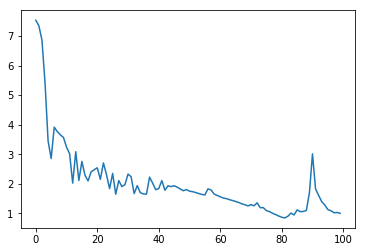

In [50]:
hidden_size = 10
window_length = 5
# encoder = EncoderRNN(window_length, hidden_size).to(device)
encoder = torch.load('pretrained_155_f5_v1')

decoder = AttnDecoderRNN(10, output_lang.n_words, dropout_p=0.1).to(device)

plt_loss = trainIters(encoder,decoder, 100, 10, print_every=1, plot_every=1)
# torch.save(encoder1,'comb_enc_025_v2')
# torch.save(decoder,'comb_dec_025_v2')

In [51]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(output_lang,sentence[1])
#         print(input_tensor)
#         print(sentence[1])
        input_length = input_tensor.size()[0]
        
        ENCODER_WINDOW = 10
        ENCODER_SLIDE = 10 # previously 1
        
        encoder_hidden = encoder.initHidden()
        encoder_h = encoder_hidden
        
        encoder_outputs = torch.zeros(max_length, 50, device=device)
        
        ct = 0
#         print(max_length)
        for ei in range(0,input_length,ENCODER_SLIDE):
            if ei < input_length-(ENCODER_WINDOW+ENCODER_SLIDE): # input_length-11:
        #             print(ei,'-',ei+ENCODER_WINDOW)
                encoder_output, encoder_hidden = encoder(input_tensor[ei:ei+ENCODER_WINDOW], encoder_hidden)
                encoder_h = encoder_hidden.view(-1)
                encoder_o = encoder_output.view(-1)
                encoder_output = torch.squeeze(encoder_output)
        #             print(encoder_hidden)
        #             print(encoder_output.data.shape)
        #         encoder_outputs[ei] = encoder_output[0, 0]
                encoder_outputs[ct] = encoder_o
                ct+=1

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        
        
        decoder_hidden = encoder_hidden.view(-1)

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
#             print('topv: ', topv,'   topi:',topi)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [53]:
def evaluateRandomly(encoder, decoder, n=10,data =10):
    for i in range(data):
        pair = random.choice(pairs[0:n])
#         print('>', pair[0].shape)
        print('Target: ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair)
        output_sentence = ' '.join(output_words)
        print('Predicted: ', output_sentence)
        print('')
        
evaluateRandomly(encoder,decoder,10,4)

Target:  go deaf school ps47 ix-1-s:s hearing family one deaf brother
Predicted:  now ix-1-s:s ix-1-s:s now ix-1-s:s will <EOS>

Target:  in fs-brooklyn in where fs-coney island have+ brother one hearing
Predicted:  now ix-1-s:s ix-1-s:s now ix-1-s:s ix-1-s:s will <EOS>

Target:  go deaf school ps47 ix-1-s:s hearing family one deaf brother
Predicted:  now ix-1-s:s ix-1-s:s now ix-1-s:s will <EOS>

Target:  old twenty-six ix-1-s:1 hearing but can sign ix-2-p:1,s tall ix-1-s:1
Predicted:  now ix-1-s:s ix-1-s:s ix-1-s:s ix-1-s:s ix-1-s:s will <EOS>



In [27]:
from nltk.translate.bleu_score import sentence_bleu

In [16]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def evaluateRandomBleu(encoder, decoder,n = 1000):
    count = 0
    bleu = 0
    for i in range(n):
        pair = random.choice(pairs)
#         print('>', pair[0])
#         print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
#         print('<', output_sentence)
#         print("BLEU = ",sentence_bleu(output_sentence,pair[1]))
        bleu+=sentence_bleu(output_sentence,pair[1])
        count+=1
    print("Average BLEU = ",bleu/count)

In [18]:
evaluateRandomly(encoder1, attn_decoder1)

NameError: name 'encoder1' is not defined

In [45]:
evaluateRandomBleu(encoder1, attn_decoder1)

Average BLEU =  0.850870240641


In [17]:
training_pairs = [get_source_target(i) for i in range(13228)]
training_pair = tra[13229]
input_tensor = training_pair[0]
target_tensor = training_pair[1]
print(input_tensor.shape)
print(target_tensor.shape)

IndexError: list index out of range

In [86]:
plt_loss = [6.94710739032993, 6.139858294696283, 6.461804585276898, 6.536206799992508, 6.685674444520324, 6.373748459275889, 5.922555854995499, 6.653567415187613, 6.30399375172313, 6.466309091751031, 6.372740593492709, 6.922924039710449, 6.098834015003968, 6.849843449647949, 6.855294610286794, 6.7453211992554625, 6.802329513200076, 6.449255983213936, 6.682626415165016, 6.4060630109164185, 6.6299963601024965, 6.789982279092084, 6.709445872096112, 6.514521597006644, 7.183025655588891, 6.905600674437871, 6.830957080177106, 6.59732552016655, 6.732748228780056, 6.291795782954331, 6.085468050428791, 6.328055061303153, 6.7273158810294635, 6.35268672493774, 6.465861165157443, 6.431174920198547, 6.338912208690736, 6.559346421069656, 6.407896386379176, 6.4978581595404785, 6.154743817322726, 6.378875143418513, 6.717904249363052, 6.98159639614943, 6.796304949950784, 6.225292253203849, 6.649223566624206, 6.310141054295798, 6.6570956249034134, 6.589642209580254, 6.3099708402025225, 5.591313724715328, 6.353971629387498, 6.666929803131471, 6.584683728103045, 6.762776139331285, 7.236614072837186, 6.756729846784455, 6.681973482607596, 6.413847853349467, 6.568357581366738, 6.029772186758285, 6.488591239416166, 7.038705739390597, 6.356290052588182, 6.742203493695033, 6.950748204263135, 6.947494322638861, 6.7334847881885835, 6.614450448802498, 6.66791578935887, 6.647181006905002, 6.8058954014064685, 7.561966250378692, 6.9113562844868595, 6.512459966820355, 6.725024547626, 6.60436262499076, 6.9103278723313215, 6.78127820483097, 6.933569145263649, 6.746349107801524, 6.847263997063485, 6.77652768007282, 6.664038922669198, 6.4655303822007575, 7.059781988017083, 6.785679811731736, 6.339695688323771, 6.642992276525715, 6.229122650076023, 6.616272164907156, 6.51950689872925, 6.567857651721544, 6.821968969850693, 6.7264443819632795, 6.390548675303815, 6.825550990841899, 6.959793106001755, 6.485100759087478, 7.257588410328717, 6.317689673097759, 6.4747215691951086, 6.483131404799979, 6.871793766736984, 6.780514576857534, 6.717987459502848, 6.554422915013259, 7.093053793124917, 6.693973005733165, 6.553635081123827, 6.828472715205816, 6.882965430326497, 6.13023586047721, 6.739642565865529, 6.3382274025884815, 5.969937975128495, 6.798067165458467, 6.226365377251528, 6.60953517942975, 6.801952267664641, 6.901095965588115, 6.87790882646246, 6.521543369574459, 6.596353981735425, 6.881275364579678, 6.754974272719454, 6.220643264438742, 6.486729228714568, 6.541163040003657, 6.463722524240064, 6.578284385972844, 7.961354583537354, 7.567724132106934, 7.153203168413018, 6.717108830873659, 7.069283112186539, 6.805175026250603, 7.240356463200986, 7.160312280575673, 6.437997172442352, 6.678887796192477, 6.791543568016478, 6.77759830439864, 6.502950289841018, 5.986891698837039, 6.32565651074456, 6.155137467357942, 5.693348801240894, 6.391734428807638, 6.698186737693558, 6.62402746144496, 6.372350268382673, 6.788021992746196, 6.634597261730285, 6.6107739128618315, 6.538785775690144, 6.774309674546729, 6.826336956931138, 6.953536406092503, 6.573256797780349, 6.629119688167936, 6.271801959151967, 6.556747471049001, 6.347326413850477, 6.386731004035506, 6.431742279921469, 6.568172880044411, 6.576985679895958, 7.225254865403573, 6.717621103196357, 6.31875971129006, 7.0117508491797995, 6.8639610206596355, 6.763610865145706, 6.470178579788318, 6.309863732468154, 6.836874012070048, 6.8332068436675515, 6.556269824635902, 7.436361503935234, 6.152275531689296, 6.855391010456734, 6.529560149067845, 6.376815811388987, 6.993457533964239, 6.08064186914115, 6.546763402950744, 6.847217265101878, 6.932996826386126, 6.270089527775147, 6.662703964439854, 6.210400503246051, 6.361114029495243, 6.241422941038602, 6.775851370932913, 6.444227126508659, 6.624845071199375, 6.428153180940869, 6.9321874044473795, 7.470104128015412, 6.8945804608724135, 6.3951184107354955, 6.530649353514433, 6.4796202159754674, 6.654751007831525, 6.769411604723228, 6.717064835484303, 6.606336189780125, 6.982407379357983, 6.938011470556805, 7.038306449873383, 6.760353461281594, 6.506474684676153, 7.062325157487663, 6.638207264895807, 6.248325291259228, 6.778468249270102, 6.489436780934173, 6.887901650608524, 6.372727364192887, 6.709179497178444, 6.513834998973887, 6.488486644426883, 6.87465392241333, 6.969075469176812, 6.29469289780678, 6.5638203704430955, 6.56524461709011, 6.983466432513563, 6.349304647424575, 5.998540926045078, 6.271909608687196, 6.738446271309437, 6.809442715647546, 7.0163211095897395, 6.531762745543541, 6.738467550339447, 6.906764883058804, 6.509702854917221, 6.589586899208894, 6.597207175920963, 6.784384066830918, 6.640888428291273, 7.241172158599145, 6.996498223480107, 6.73484784599689, 6.382327967580275, 6.593329814252226, 6.929445130442434, 6.991374778814955, 6.419015780848796, 6.977392983376282, 6.498090841349747, 6.227057934076503, 6.895048179058355, 6.5485349674389575, 6.419639414470712, 6.482722851184405, 6.369601737543053, 6.8680148115533886, 6.769833795396933, 6.376441683067105, 6.477527227050196, 6.556201763987202, 6.441602424505287, 6.830237094727441, 6.798933186356595, 6.9260930995697025, 6.74311146229639, 6.604954588619751, 6.881599993914397, 6.849338341455577, 6.3989736194851625, 6.59370771406468, 6.616338066421429, 6.573869717579795, 6.372728192916671, 6.569852253173943, 6.947427048976891, 6.858134193316101, 7.174698850643772, 6.241158505859662, 6.624560276697346, 6.821975662275621, 6.6052052931863185, 6.891963285821171, 6.385310218978054, 6.375315575891766, 6.57189288628447, 6.465181716160322, 6.798070021715241, 6.8561118553289395, 6.793864941513802, 6.8852384154890345, 6.619655781980139, 6.5442054906977525, 6.694200425046659, 7.228263164989576, 7.104252023852004, 7.280014609159528, 7.4939279681633435, 6.534159340067789, 7.092046035229124, 6.908995810128901, 6.403010812466652, 7.078624056087531, 6.554467508282577, 6.613213641671955, 6.471050858624686, 6.732979497411325, 6.819453863992071, 6.511892823618375, 7.037582334509427, 6.937174795502111, 6.2791123245953555, 6.663697880752482, 6.691650096856425, 6.720738241600441, 6.5554115368612464, 6.374723825729659, 6.642066574699262, 6.644235154977342, 6.543805507938429, 6.740731691234585, 7.103874536696676, 6.308970420400675, 6.875592274251099, 6.342310086287651, 6.712479889182316, 6.656251803608621, 6.711614036253873, 7.056452510599894, 6.6684231991398555, 6.971107082360987, 6.689229605714324, 6.867062617360884, 6.413059201523599, 6.554719605456162, 6.514337500377988, 6.821431333422145, 6.562218877707195, 6.865000730392957, 6.608899502991176, 6.514955662521985, 6.734065817666623, 6.643510637833592, 6.7811456139063955, 6.878653337341857, 6.793355169599031, 6.791947106922935, 6.401439008689696, 6.829577496682841, 6.3595342457678, 6.138831541443674, 6.7612474839813546, 6.973232318431955, 6.347403579776207, 6.567184886660515, 7.189913945726514, 6.40237761797297, 6.451484562386496, 6.637669915943081, 6.503654200652192, 6.267386441866113, 6.387939748890819, 6.867063097237743, 6.894636932177043, 6.770937711783137, 6.982268229380077, 6.554804226507452, 7.012403830034375, 6.441150557134976, 6.753661577753297, 6.542039398933045, 6.3611596562521076, 7.229291199558049, 6.771188970245696, 6.960259183220461, 6.481101810933103, 6.748330782010308, 6.791246725108855, 6.931764575548928, 6.792089524453001, 6.62358557333033, 6.483483286249307, 6.450576002430076, 6.4989366868917955, 6.76632628057346, 6.661341012754287, 6.4738303719257875, 6.231594342230588, 6.646381675739709, 6.944287456098562, 7.3575160836139775, 6.857743630659322, 6.993050542669576, 6.954650052798996, 7.231371630950252, 6.409884501031664, 6.993019681854025, 7.18141807495473, 6.835477782291808, 6.825253942348123, 7.066160294598152, 7.042017094877706, 6.748223583095612, 6.968834566851319, 7.000144240699013, 7.125111547586238, 6.743745827618046, 6.474974228273725, 6.915154555637083, 6.837432937349063, 6.95496552877446, 6.999440502125283, 6.750374232528543, 6.954355347135154, 6.732366146467935, 6.698728410456514, 6.6501064437282915, 7.300067049002865, 7.1986243280547635, 6.865228868511597, 6.510359657147335, 6.304917940436993, 6.956322217826323, 7.170542306738398, 6.944330117160647, 6.904687048482285, 7.118136143258795, 6.925036708473346, 6.762412356928654, 7.024833348264399, 6.653935987370512, 6.976045310374714, 7.103456583428286, 6.7894648666734705, 6.911300130005556, 6.931219908156321, 6.904336576183485, 7.557437889934136, 7.081134975600724, 6.987202423801449, 6.6307740786662475, 7.138448598414431, 6.915097826275774, 6.540370768359541, 6.663528549508669, 7.085737971436825, 6.76683520278652, 6.981867424870751, 6.773173204391919, 6.76923015575812, 7.001850513861776, 7.000873900720976, 6.973164106024308, 6.983153095891963, 6.815219355655561, 7.107631715891397, 6.658758475147287, 6.679424596436021, 6.590628735236503, 6.318908505462753, 7.408355935633713, 6.88473816378489, 6.501262117172679, 6.512915221042351, 6.667629349683392, 7.315880077997896, 6.4705203461888825, 6.553002054351435, 6.949813948890806, 6.80202000266355, 6.9041815525419885, 6.293317428166281, 6.556853154286698, 7.043216117701503, 7.138835685826741, 6.74611151043417, 6.693297618720263, 7.115392620642596, 7.6563837849434, 7.571603073889853, 7.2791457545753095, 6.807896466721482, 6.538834483487046, 6.00186218357877, 6.56201045573107, 6.624534111683146, 6.589783453648838, 6.933298109863079, 6.168583589928253, 6.778020670247048, 6.541467150916076, 6.87460666004127, 6.832831295414073, 6.729433838960317, 6.35120638206729, 6.358958540460693]
#44 sentences, 0.01 lr, adam, shape same, epoch 500, sentences 100, loss zigzag ## WITHOUT PRETRAINING
plt.plot(plt_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('NLLLoss Value')
plt.title('Loss curve for Ender-Decoder architecture')

Text(0.5,1.05,u'Loss curve for Ender-Decoder architecture')

In [87]:
print(plt_loss)
#44 sentences, 0.01 lr, adam, shape same, epoch 500, sentences 100, loss zigzag ## WITHOUT PRETRAINING
plt.plot(plt_loss)

[6.94710739032993, 6.139858294696283, 6.461804585276898, 6.536206799992508, 6.685674444520324, 6.373748459275889, 5.922555854995499, 6.653567415187613, 6.30399375172313, 6.466309091751031, 6.372740593492709, 6.922924039710449, 6.098834015003968, 6.849843449647949, 6.855294610286794, 6.7453211992554625, 6.802329513200076, 6.449255983213936, 6.682626415165016, 6.4060630109164185, 6.6299963601024965, 6.789982279092084, 6.709445872096112, 6.514521597006644, 7.183025655588891, 6.905600674437871, 6.830957080177106, 6.59732552016655, 6.732748228780056, 6.291795782954331, 6.085468050428791, 6.328055061303153, 6.7273158810294635, 6.35268672493774, 6.465861165157443, 6.431174920198547, 6.338912208690736, 6.559346421069656, 6.407896386379176, 6.4978581595404785, 6.154743817322726, 6.378875143418513, 6.717904249363052, 6.98159639614943, 6.796304949950784, 6.225292253203849, 6.649223566624206, 6.310141054295798, 6.6570956249034134, 6.589642209580254, 6.3099708402025225, 5.591313724715328, 6.3539716

[4.778003598220103, 3.63999743798997, 3.79804478860218, 3.5465842641482617, 3.2526754403378972, 3.494275049587893, 3.0171227766535877, 3.0713673143339584, 3.452485509962594, 3.1257733138617154, 2.9186282931798826, 2.870388975504994, 2.9389705397845147, 3.052896449785645, 2.8913774976283393, 2.684959001572201, 2.6046544602133985, 2.907523517528278, 2.6095818878367156, 2.8264831148687057, 2.7023126079435342, 2.5363673054901894, 2.8238848371045693, 2.422664249796967, 2.46746290808691, 2.4964034721732773, 2.6209206203570057, 2.1824362159159287, 2.3078979838410008, 2.132668973139325, 2.369281379431281, 2.1263606409177203, 2.269531150962126, 2.2478860337744155, 2.3562879754537764, 2.42275329482936, 2.240367239841026, 1.8447799302432446, 2.4277890286922577, 2.014547885696705, 2.190280765914146, 2.013672243034856, 1.9688296000944123, 1.936697132915901, 2.1374472936576256, 2.227222639439181, 2.241796503249412, 2.2206267746318256, 2.300666417749448, 2.1527743633180125, 2.1946475113501234, 1.8459

Text(0.5,1,u'Encoder-Decoder Combined loss curve')

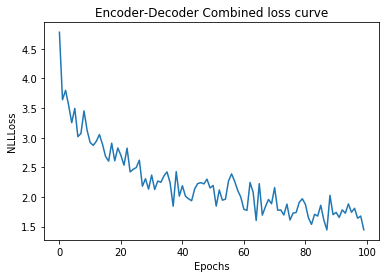

In [62]:
print(plt_loss)
#44 sentences, 0.001 lr, adam, shape same, epoch 100, sentences 100, loss 4.7 to 1.6 ## WITH PRETRAINING
plt.plot(plt_loss)
plt.xlabel('Epochs')
plt.ylabel('NLLLoss')
plt.title('Encoder-Decoder Combined loss curve')

[4.723870254214848, 4.191029266741442, 3.906103208263515, 3.7954641934000466, 3.4636422011903476, 3.3927079479057545, 3.23530555914825, 3.227974128795466, 3.0791040313884803, 3.0933658107183803, 3.0554143966959133, 2.952217607014004, 2.9894677699425647, 2.9956909249621755, 2.9047184713959466, 2.8600934171003303, 2.903451263441562, 2.9131505176454455, 2.8419718270946404, 2.775005655598828, 2.801243263335161, 2.7799463678084333, 2.896516859313195, 2.7151675617742317, 2.7281381660788004, 2.607414012526558, 2.6429898757402905, 2.6400835660448774, 2.698896511886822, 2.5863039805692023, 2.625263578070632, 2.7004775932754654, 2.6411976161422155, 2.494176101181339, 2.731807458313645, 2.6241944967141824, 2.5896771099045934, 2.6454252595819265, 2.5669186313619297, 2.5660522640665846, 2.697803275436203, 2.557074835772231, 2.446983807526843, 2.711878206267767, 2.64104762268243, 2.635120347873953, 2.6126389974771858, 2.589933118520693, 2.5955682338464987, 2.5629093085791204, 2.5516965034071473, 2.5

Text(0.5,1,u'Encoder-Decoder Combined loss curve')

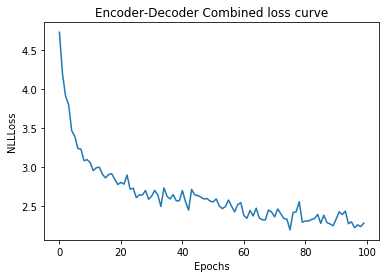

In [112]:
print(plt_loss)
#44 sentences, 0.001 lr, adam, shape same, epoch 100, sentences 800, loss 4.7 to 2.3 ## WITH PRETRAINING, ADAM #025_v2
plt.plot(plt_loss)
plt.xlabel('Epochs')
plt.ylabel('NLLLoss')
plt.title('Encoder-Decoder Combined loss curve')

In [ ]:
x = get_sentence_data()

In [202]:
ei = 0
ENCODER_WINDOW = 10
encoder = torch.load('pretrained_274_v1')
encoder_hidden = encoder.initHidden()
with torch.no_grad():
    encoder_output1, encoder_hidden = encoder(training_pairs[1][0][ei:ei+ENCODER_WINDOW], encoder_hidden)
    ei = 4
    encoder_output2, encoder_hidden = encoder(training_pairs[1][0][ei:ei+ENCODER_WINDOW], encoder_hidden)
    ei = 4
    encoder_output3, encoder_hidden = encoder(training_pairs[1][0][ei:ei+ENCODER_WINDOW], encoder_hidden)

In [203]:
print(torch.dist(encoder_output1,encoder_output2))
print(torch.dist(encoder_output1,encoder_output3))

tensor(3335.2637, device='cuda:0')
tensor(3406.2720, device='cuda:0')


In [96]:
print(training_pairs[0][0])

tensor([[206.7770, 196.1540, 196.5970,  ..., 302.0320, 295.4680, 322.8660],
        [202.2420, 150.3320, 169.6880,  ..., 302.9280, 296.7430, 325.4560],
        [167.6720, 147.7980, 165.8230,  ..., 304.0680, 296.7880, 326.7850],
        ...,
        [247.3250, 210.8560, 244.7200,  ..., 298.9110, 294.1600, 320.2950],
        [283.6340, 206.0550, 239.1560,  ..., 299.0650, 294.1780, 320.3060],
        [204.3270, 252.8650, 269.9340,  ..., 299.2700, 295.4240, 321.5640]],
       device='cuda:0')
